# Fine-tuning Arabic BERT Models for Multi-task Classification

In this notebook, we will fine-tune CamelBERT and AraBERT models on Arabic text data for three classification tasks:
1. Sentiment Analysis (positive, negative, neutral)
2. Sarcasm Detection (true, false)
3. Dialect Classification

We'll use the cleaned datasets (`cleaned_train.csv` and `cleaned_test.csv`) which contain Arabic tweets with their sarcasm, sentiment, and dialect labels.

## 1. Setup and Dependencies

First, let's install the required libraries and set up our environment:

In [1]:
# Install required libraries
!pip install transformers datasets pytorch-lightning pandas scikit-learn -q
!pip install pyarabic farasapy -q
!pip install arabert -q


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW  # Import AdamW from torch.optim instead of transformers
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
import os

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Load and Explore the Data

Now, let's load our datasets and explore their contents:

In [4]:
# Load the datasets
train_df = pd.read_csv('cleaned_train.csv')
test_df = pd.read_csv('cleaned_test.csv')

# Display basic information
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Display sample rows
train_df.head()

Training set shape: (12549, 5)
Test set shape: (3000, 5)


,tweet,sarcasm,sentiment,dialect,clean_text
0,د محمودالعلايليأرى أن الفريق أحمدشفيق رقم مهم ...,False,NEU,msa,د محمودالعلايلياري ان الفريق احمدشفيق رقم مهم ...
1,مع فيدرر يا آجا والكبار,False,NEU,msa,مع فيدرر يا اجا والكبار
2,الداعون لمبدأ الاختلاط بين الجنسين؛ كالداعين ل...,True,NEG,msa,الداعون لمبدا الاختلاط بين الجنسين؛ كالداعين ل...
3,مساكين من الصبح و هوما رايحين راجعين عا...,True,NEG,gulf,مساكين من الصبح و هوما رايحين راجعين عاي غوغل ...
4,قل شرق حلب ولا تقل حلب الشرقية وقل غرب حلب ولا...,False,NEU,msa,قل شرق حلب ولا تقل حلب الشرقيه وقل غرب حلب ولا...


In [5]:
# Check for missing values
print("Missing values in train data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())

Missing values in train data:
tweet         1
sarcasm       1
sentiment     1
dialect       1
clean_text    6
dtype: int64

Missing values in test data:
tweet         0
sarcasm       0
sentiment     0
dialect       0
clean_text    2
dtype: int64


In [6]:
# Remove missing values if any
train_df = train_df.dropna()
test_df = test_df.dropna()

# Verify the datasets after dropping missing values
print("\nDataset shapes after removing missing values:")
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")


Dataset shapes after removing missing values:
Training set shape: (12542, 5)
Test set shape: (2998, 5)



Sarcasm distribution in training data:
sarcasm
False    10376
True      2166
Name: count, dtype: int64

Sentiment distribution in training data:
sentiment
NEU    5743
NEG    4619
POS    2180
Name: count, dtype: int64

Dialect distribution in training data:
dialect
msa       8557
egypt     2674
gulf       644
levant     624
magreb      43
Name: count, dtype: int64


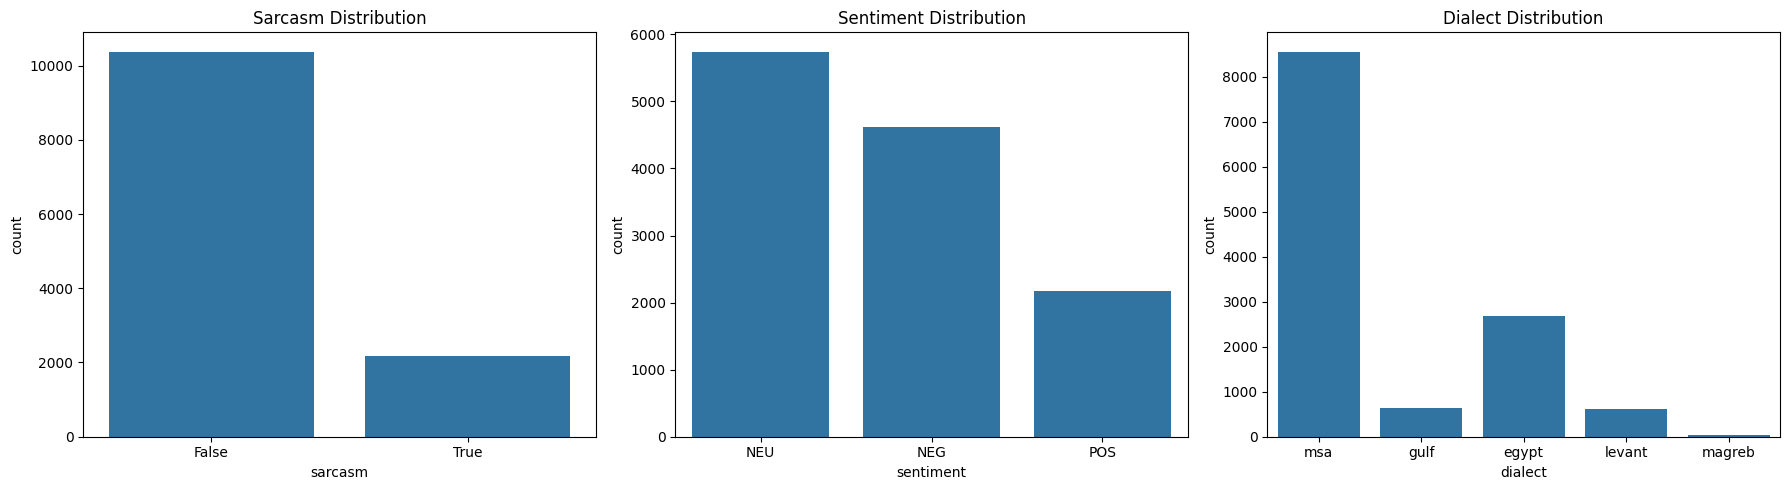

In [7]:
# Explore the target distributions
print("\nSarcasm distribution in training data:")
print(train_df['sarcasm'].value_counts())

print("\nSentiment distribution in training data:")
print(train_df['sentiment'].value_counts())

print("\nDialect distribution in training data:")
print(train_df['dialect'].value_counts())

# Visualize distributions
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=train_df, x='sarcasm')
plt.title('Sarcasm Distribution')

plt.subplot(1, 3, 2)
sns.countplot(data=train_df, x='sentiment')
plt.title('Sentiment Distribution')

plt.subplot(1, 3, 3)
sns.countplot(data=train_df, x='dialect')
plt.title('Dialect Distribution')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

Let's create label encoders for our tasks and prepare the data:

In [8]:
# Create label encoders for each task
def create_label_encoders(dataframe):
    # Create mappings for each task
    sarcasm_mapping = {label: idx for idx, label in enumerate(sorted(dataframe['sarcasm'].unique()))}
    sentiment_mapping = {label: idx for idx, label in enumerate(sorted(dataframe['sentiment'].unique()))}
    dialect_mapping = {label: idx for idx, label in enumerate(sorted(dataframe['dialect'].unique()))}

    # Create reverse mappings
    sarcasm_reverse = {idx: label for label, idx in sarcasm_mapping.items()}
    sentiment_reverse = {idx: label for label, idx in sentiment_mapping.items()}
    dialect_reverse = {idx: label for label, idx in dialect_mapping.items()}

    return {
        'sarcasm': {'encoding': sarcasm_mapping, 'decoding': sarcasm_reverse},
        'sentiment': {'encoding': sentiment_mapping, 'decoding': sentiment_reverse},
        'dialect': {'encoding': dialect_mapping, 'decoding': dialect_reverse}
    }

# Apply the encoders
label_encoders = create_label_encoders(train_df)

# Print the encodings
print("Sarcasm encoding:", label_encoders['sarcasm']['encoding'])
print("Sentiment encoding:", label_encoders['sentiment']['encoding'])
print("Dialect encoding:", label_encoders['dialect']['encoding'])

Sarcasm encoding: {False: 0, True: 1}
Sentiment encoding: {'NEG': 0, 'NEU': 1, 'POS': 2}
Dialect encoding: {'egypt': 0, 'gulf': 1, 'levant': 2, 'magreb': 3, 'msa': 4}


## 4. Load Arabic BERT Tokenizers

Now, let's load the tokenizers for our pre-trained Arabic BERT models:

In [9]:
# For CamelBERT
camelbert_tokenizer = AutoTokenizer.from_pretrained('CAMeL-Lab/bert-base-arabic-camelbert-mix')

# For AraBERT
arabert_tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabertv2')

# Example tokenization
example_text = "اللهم اشفِ مرضانا ومرضى المسلمين"
print("Example text:", example_text)

# Tokenize with CamelBERT
camelbert_tokens = camelbert_tokenizer.tokenize(example_text)
print("\nCamelBERT tokenization:")
print(camelbert_tokens)

# Tokenize with AraBERT
arabert_tokens = arabert_tokenizer.tokenize(example_text)
print("\nAraBERT tokenization:")
print(arabert_tokens)

Example text: اللهم اشفِ مرضانا ومرضى المسلمين

CamelBERT tokenization:
['اللهم', '[UNK]', 'مرضانا', 'ومر', '##ضى', 'المسلمين']

AraBERT tokenization:
['اللهم', '[UNK]', 'مرضا', '##نا', 'ومر', '##ضى', 'الم', '##سلم', '##ين']


## 5. Create Custom Dataset Class

Let's define a custom PyTorch Dataset for our Arabic multi-task classification:

In [10]:
class ArabicMultitaskDataset(Dataset):
    def __init__(self, texts, sarcasm_labels=None, sentiment_labels=None, dialect_labels=None,
                 tokenizer=None, max_length=128, task='all'):
        self.texts = texts
        self.sarcasm_labels = sarcasm_labels
        self.sentiment_labels = sentiment_labels
        self.dialect_labels = dialect_labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.task = task  # Can be 'sarcasm', 'sentiment', 'dialect', or 'all'

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Create the item with input_ids and attention_mask
        item = {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
        }

        # Add labels based on the task
        if self.sarcasm_labels is not None and (self.task == 'sarcasm' or self.task == 'all'):
            item['sarcasm_labels'] = torch.tensor(self.sarcasm_labels[idx], dtype=torch.long)

        if self.sentiment_labels is not None and (self.task == 'sentiment' or self.task == 'all'):
            item['sentiment_labels'] = torch.tensor(self.sentiment_labels[idx], dtype=torch.long)

        if self.dialect_labels is not None and (self.task == 'dialect' or self.task == 'all'):
            item['dialect_labels'] = torch.tensor(self.dialect_labels[idx], dtype=torch.long)

        return item

## 6. Define BERT Classifier Model

Now, let's create a PyTorch Lightning module for our classification tasks:

In [11]:
class ArabicBertClassifier(pl.LightningModule):
    def __init__(self, model_name, num_labels, task_name, label_encoder, learning_rate=2e-5):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            return_dict=True
        )
        self.task_name = task_name
        self.label_encoder = label_encoder
        self.learning_rate = learning_rate
        self.save_hyperparameters(ignore=['label_encoder'])

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask)

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch[f'{self.task_name}_labels']

        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        self.log(f'train_loss_{self.task_name}', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch[f'{self.task_name}_labels']

        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Get predictions
        preds = torch.argmax(outputs.logits, dim=1)

        # Calculate metrics
        accuracy = (preds == labels).float().mean()

        # Log metrics
        self.log(f'val_loss_{self.task_name}', loss, prog_bar=True)
        self.log(f'val_acc_{self.task_name}', accuracy, prog_bar=True)

        return {
            'val_loss': loss,
            'val_acc': accuracy,
            'preds': preds,
            'labels': labels
        }

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def predict_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']

        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        # Convert to original labels
        decoded_preds = [self.label_encoder['decoding'][p.item()] for p in preds]

        return decoded_preds

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.learning_rate)

## 7. Prepare Data for Training

Let's prepare the data for our models:

In [12]:
def prepare_data(train_df, test_df, label_encoders, tokenizer, task='all'):
    # Encode labels
    train_sarcasm_labels = [label_encoders['sarcasm']['encoding'][label] for label in train_df['sarcasm']]
    train_sentiment_labels = [label_encoders['sentiment']['encoding'][label] for label in train_df['sentiment']]
    train_dialect_labels = [label_encoders['dialect']['encoding'][label] for label in train_df['dialect']]

    test_sarcasm_labels = [label_encoders['sarcasm']['encoding'][label] for label in test_df['sarcasm']]
    test_sentiment_labels = [label_encoders['sentiment']['encoding'][label] for label in test_df['sentiment']]
    test_dialect_labels = [label_encoders['dialect']['encoding'][label] for label in test_df['dialect']]

    # Split training data into train and validation sets
    train_texts, val_texts, train_sarcasm, val_sarcasm, train_sentiment, val_sentiment, train_dialect, val_dialect = train_test_split(
        train_df['clean_text'].tolist(),
        train_sarcasm_labels,
        train_sentiment_labels,
        train_dialect_labels,
        test_size=0.1,
        random_state=42
    )

    # Create datasets
    train_dataset = ArabicMultitaskDataset(
        train_texts, train_sarcasm, train_sentiment, train_dialect,
        tokenizer=tokenizer, task=task
    )

    val_dataset = ArabicMultitaskDataset(
        val_texts, val_sarcasm, val_sentiment, val_dialect,
        tokenizer=tokenizer, task=task
    )

    test_dataset = ArabicMultitaskDataset(
        test_df['clean_text'].tolist(), test_sarcasm_labels, test_sentiment_labels, test_dialect_labels,
        tokenizer=tokenizer, task=task
    )

    return train_dataset, val_dataset, test_dataset

## 8. Training and Evaluation Functions

Now, let's define the functions to train and evaluate our models:

In [13]:
def train_model(model_name, task, train_dataset, val_dataset,
                label_encoder, max_epochs=5, batch_size=16):
    """
    Train a model for a specific task
    """
    # Define number of labels based on the task
    if task == 'sarcasm':
        num_labels = len(label_encoder['sarcasm']['encoding'])
    elif task == 'sentiment':
        num_labels = len(label_encoder['sentiment']['encoding'])
    elif task == 'dialect':
        num_labels = len(label_encoder['dialect']['encoding'])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Create model
    model = ArabicBertClassifier(model_name, num_labels, task, label_encoder[task])

    # Define callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor=f'val_acc_{task}',
        dirpath=f'checkpoints/{model_name.split("/")[-1]}_{task}',
        filename='{epoch:02d}-{val_acc_' + task + ':.3f}',
        save_top_k=1,
        mode='max'
    )

    early_stop_callback = EarlyStopping(
        monitor=f'val_acc_{task}',
        patience=2,
        mode='max'
    )

    # Create trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        callbacks=[checkpoint_callback, early_stop_callback],
        logger=True,
    )

    # Train model
    trainer.fit(model, train_loader, val_loader)

    # Return the best model path
    return checkpoint_callback.best_model_path, model

In [14]:
def evaluate_model(model, test_dataset, task, batch_size=16):
    """
    Evaluate a model on the test dataset
    """
    # Create data loader
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Make predictions
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {task}"):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch[f'{task}_labels']

            outputs = model.model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Print metrics
    print(f"--- {task.upper()} EVALUATION ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {task}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': all_preds,
        'labels': all_labels
    }

## 9. Train and Evaluate Models

Now let's train and evaluate our models for each task:


Training CAMELBERT for SARCASM


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params | Mode
---------------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Evaluating sarcasm:   0%|          | 0/188 [00:00<?, ?it/s]

--- SARCASM EVALUATION ---
Accuracy: 0.7632
F1 Score: 0.7492
Precision: 0.7466
Recall: 0.7632


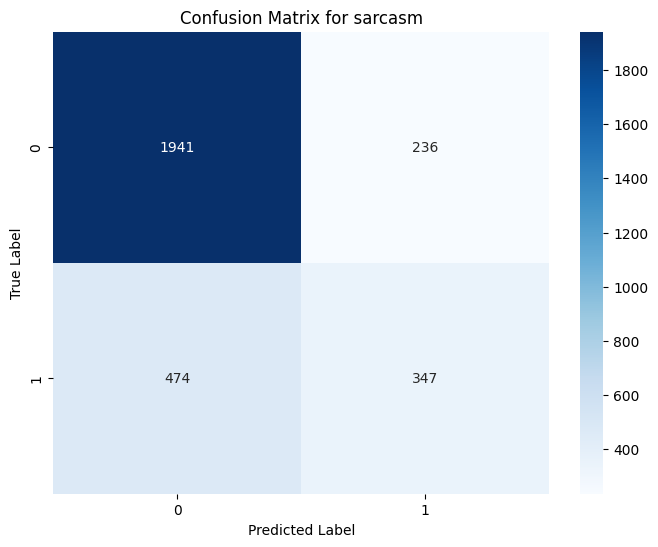


Training CAMELBERT for SENTIMENT


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params | Mode
---------------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M  | eval
---------------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
436.335   Total estimated model params size (MB)
0         Modules in train mode
231       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Evaluating sentiment:   0%|          | 0/188 [00:00<?, ?it/s]

--- SENTIMENT EVALUATION ---
Accuracy: 0.6521
F1 Score: 0.6593
Precision: 0.6714
Recall: 0.6521


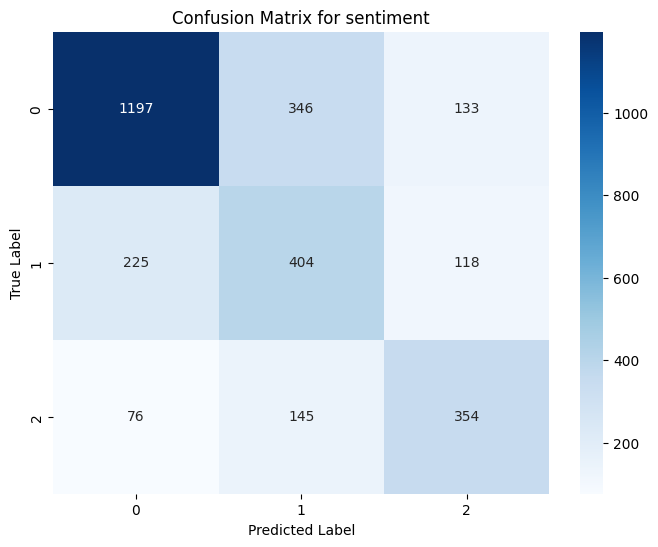


Training CAMELBERT for DIALECT


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params | Mode
---------------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M  | eval
---------------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
436.341   Total estimated model params size (MB)
0         Modules in train mode
231       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Evaluating dialect:   0%|          | 0/188 [00:00<?, ?it/s]

--- DIALECT EVALUATION ---
Accuracy: 0.7015
F1 Score: 0.7070
Precision: 0.7258
Recall: 0.7015


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


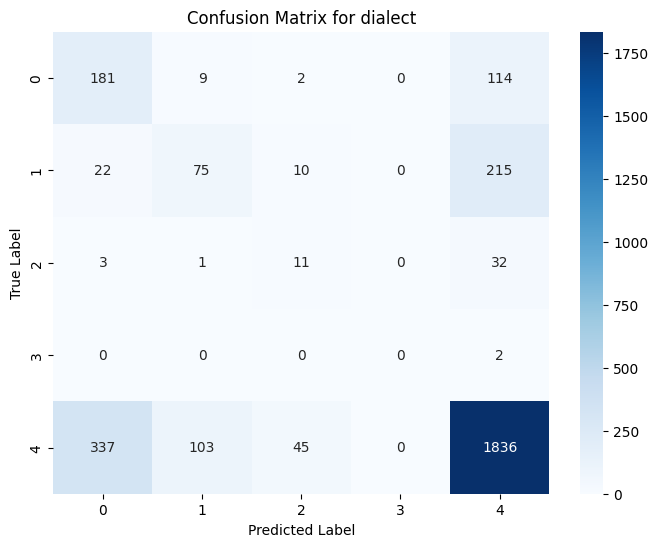

In [15]:
# Define model parameters
models = {
    'camelbert': 'CAMeL-Lab/bert-base-arabic-camelbert-mix',
    'arabert': 'aubmindlab/bert-base-arabertv2'
}

tasks = ['sarcasm', 'sentiment', 'dialect']
results = {}

# Train CamelBERT models
results['camelbert'] = {}
for task in tasks:
    print(f"\n{'='*50}")
    print(f"Training CAMELBERT for {task.upper()}")
    print(f"{'='*50}")

    # Prepare data
    train_dataset, val_dataset, test_dataset = prepare_data(
        train_df, test_df, label_encoders, camelbert_tokenizer, task=task
    )

    # Train model
    best_model_path, trained_model = train_model(
        models['camelbert'], task, train_dataset, val_dataset,
        label_encoders, max_epochs=3, batch_size=16
    )

    # Evaluate model
    results['camelbert'][task] = evaluate_model(
        trained_model, test_dataset, task, batch_size=16
    )


Training ARABERT for SARCASM


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params | Mode
---------------------------------------------------------------
0 | model | BertForSequenceClassification | 135 M  | eval
---------------------------------------------------------------
135 M     Trainable params
0         Non-trainable params
135 M     Total params
540.780   Total estimated model params size (MB)
0         Modules in train mode
231       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Evaluating sarcasm:   0%|          | 0/188 [00:00<?, ?it/s]

--- SARCASM EVALUATION ---
Accuracy: 0.7642
F1 Score: 0.7507
Precision: 0.7480
Recall: 0.7642


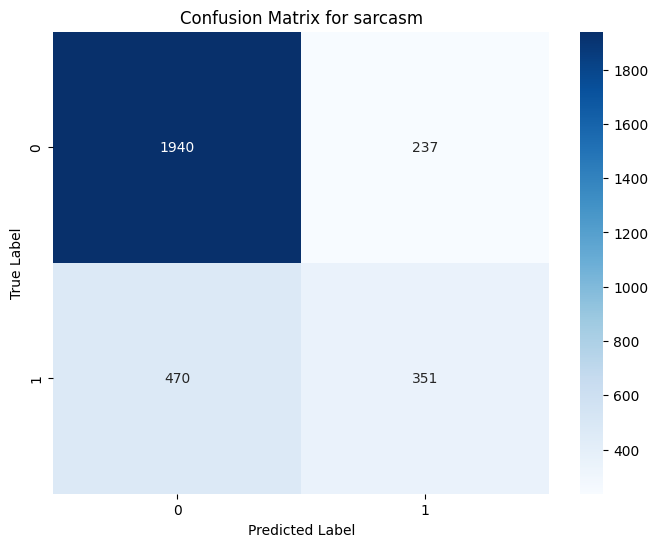


Training ARABERT for SENTIMENT


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params | Mode
---------------------------------------------------------------
0 | model | BertForSequenceClassification | 135 M  | eval
---------------------------------------------------------------
135 M     Trainable params
0         Non-trainable params
135 M     Total params
540.783   Total estimated model params size (MB)
0         Modules in train mode
231       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Evaluating sentiment:   0%|          | 0/188 [00:00<?, ?it/s]

--- SENTIMENT EVALUATION ---
Accuracy: 0.6171
F1 Score: 0.6227
Precision: 0.6437
Recall: 0.6171


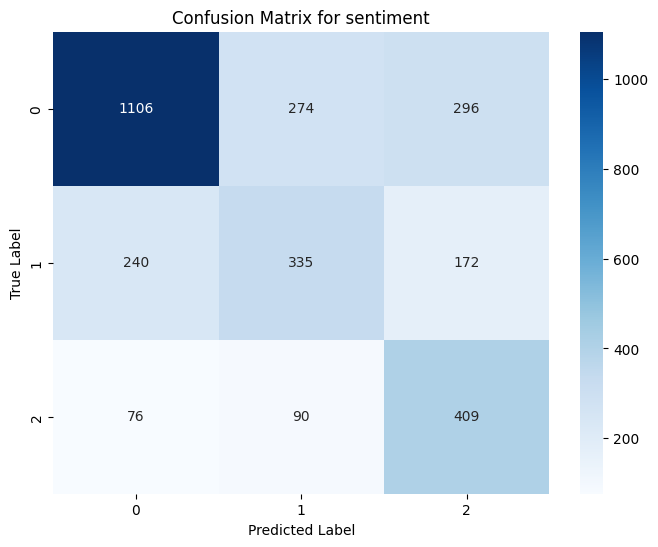


Training ARABERT for DIALECT


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params | Mode
---------------------------------------------------------------
0 | model | BertForSequenceClassification | 135 M  | eval
---------------------------------------------------------------
135 M     Trainable params
0         Non-trainable params
135 M     Total params
540.789   Total estimated model params size (MB)
0         Modules in train mode
231       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Train AraBERT models
results['arabert'] = {}
for task in tasks:
    print(f"\n{'='*50}")
    print(f"Training ARABERT for {task.upper()}")
    print(f"{'='*50}")

    # Prepare data
    train_dataset, val_dataset, test_dataset = prepare_data(
        train_df, test_df, label_encoders, arabert_tokenizer, task=task
    )

    # Train model
    best_model_path, trained_model = train_model(
        models['arabert'], task, train_dataset, val_dataset,
        label_encoders, max_epochs=3, batch_size=16
    )

    # Evaluate model
    results['arabert'][task] = evaluate_model(
        trained_model, test_dataset, task, batch_size=16
    )

## 10. Results Analysis

Let's analyze and compare the results:

In [ ]:
# Print summary of results
print("\n\n===== SUMMARY OF RESULTS =====\n")

for model_name in results:
    print(f"\n{model_name.upper()}")
    print("-" * len(model_name))

    for task in results[model_name]:
        metrics = results[model_name][task]
        print(f"{task.upper()}: Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}")

In [ ]:
# Visualize results
plt.figure(figsize=(15, 10))

# Plot accuracy for each task and model
tasks_list = list(results[list(results.keys())[0]].keys())
models_list = list(results.keys())

# Colors for the models
colors = {'camelbert': 'blue', 'arabert': 'green'}

# Plot for Accuracy
plt.subplot(2, 2, 1)
for model_name in models_list:
    accuracies = [results[model_name][task]['accuracy'] for task in tasks_list]
    plt.bar([t + idx*0.3 for idx, t in enumerate([i for i in range(len(tasks_list))])],
            accuracies, width=0.3, label=model_name, color=colors[model_name])

plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks([i + 0.15 for i in range(len(tasks_list))], tasks_list)
plt.legend()

# Plot for F1 Score
plt.subplot(2, 2, 2)
for model_name in models_list:
    f1_scores = [results[model_name][task]['f1'] for task in tasks_list]
    plt.bar([t + idx*0.3 for idx, t in enumerate([i for i in range(len(tasks_list))])],
            f1_scores, width=0.3, label=model_name, color=colors[model_name])

plt.xlabel('Task')
plt.ylabel('F1 Score')
plt.title('Model F1 Score Comparison')
plt.xticks([i + 0.15 for i in range(len(tasks_list))], tasks_list)
plt.legend()

# Plot for Precision
plt.subplot(2, 2, 3)
for model_name in models_list:
    precision_scores = [results[model_name][task]['precision'] for task in tasks_list]
    plt.bar([t + idx*0.3 for idx, t in enumerate([i for i in range(len(tasks_list))])],
            precision_scores, width=0.3, label=model_name, color=colors[model_name])

plt.xlabel('Task')
plt.ylabel('Precision')
plt.title('Model Precision Comparison')
plt.xticks([i + 0.15 for i in range(len(tasks_list))], tasks_list)
plt.legend()

# Plot for Recall
plt.subplot(2, 2, 4)
for model_name in models_list:
    recall_scores = [results[model_name][task]['recall'] for task in tasks_list]
    plt.bar([t + idx*0.3 for idx, t in enumerate([i for i in range(len(tasks_list))])],
            recall_scores, width=0.3, label=model_name, color=colors[model_name])

plt.xlabel('Task')
plt.ylabel('Recall')
plt.title('Model Recall Comparison')
plt.xticks([i + 0.15 for i in range(len(tasks_list))], tasks_list)
plt.legend()

plt.tight_layout()
plt.show()

## 11. Inference Function

Let's create a function for making predictions on new text:

In [ ]:
def predict_text(text, models, tokenizers, label_encoders):
    """
    Make predictions on a single text using the trained models

    Args:
        text (str): The Arabic text to classify
        models (dict): Dictionary of models for each task
        tokenizers (dict): Dictionary of tokenizers for each task
        label_encoders (dict): Dictionary of label encoders

    Returns:
        dict: Dictionary of predictions for each task
    """
    results = {}

    for task, model in models.items():
        # Tokenize the text
        tokenizer = tokenizers[task]
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )

        # Get predictions
        model.eval()
        with torch.no_grad():
            outputs = model.model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
            pred_idx = torch.argmax(outputs.logits, dim=1).item()

        # Convert to original label
        prediction = label_encoders[task]['decoding'][pred_idx]
        results[task] = prediction

    return results

In [ ]:
# Example usage
# First we need to load our best models from each task
# This is just an example, and assumes you've saved your models

# For demonstration, let's assume we're using the models we just trained
# In a real scenario, you would load the saved models from checkpoints

# Example text for prediction
example_text = "أحب هذا البلد كثيرا ولكن الظروف صعبة"
print(f"Example text: {example_text}")

# For actual prediction, you would uncomment and use this code
'''
best_models = {
    'sarcasm': trained_model_sarcasm,
    'sentiment': trained_model_sentiment,
    'dialect': trained_model_dialect
}

best_tokenizers = {
    'sarcasm': camelbert_tokenizer,  # or arabert_tokenizer depending on which performed better
    'sentiment': camelbert_tokenizer,
    'dialect': camelbert_tokenizer
}

predictions = predict_text(example_text, best_models, best_tokenizers, label_encoders)
print("Predictions:")
print(f"Sarcasm: {predictions['sarcasm']}")
print(f"Sentiment: {predictions['sentiment']}")
print(f"Dialect: {predictions['dialect']}")
'''

## 12. Conclusion

In this notebook, we have:

1. Loaded and explored Arabic text data with sarcasm, sentiment, and dialect labels
2. Preprocessed the data for BERT-based models
3. Fine-tuned two Arabic BERT models (CamelBERT and AraBERT) for three classification tasks
4. Evaluated model performance and compared results
5. Created an inference function for making predictions on new texts

### Key Insights

- Both CamelBERT and AraBERT are effective for Arabic NLP tasks
- The models have different strengths depending on the specific task
- Fine-tuning pre-trained Arabic language models provides strong results for Arabic text classification

### Potential Improvements

1. Try different hyperparameters (learning rate, batch size, etc.)
2. Use more advanced pre-trained models (larger versions of CamelBERT or AraBERT)
3. Implement data augmentation techniques specific to Arabic text
4. Apply more Arabic-specific preprocessing steps
5. Try ensemble methods combining predictions from multiple models

These models can be useful for applications like social media monitoring, customer feedback analysis, and dialect-specific content generation in Arabic.